# Tarea 2
## Profesor: Dr. Esteban Vargas; Alumno: Enrique Reyes
### 10/12/2020

El conjunto de datos a análizar contiene información sobre los reportes de contagios, recuperados y muertes diarias de SARS-CoV-2 Covid-19, de Uruguay (13 de marzo a 21 de junio de 2020), Nigeria (20 de marzo a 29 de junio de 2020) y Filipinas (06 de marzo a 15 de junio de 2020).

## 1. Carga de paquetes y datos

In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

In [2]:
import PDEparams as pde

In [3]:
# Cargamos los datos
URU = pd.read_csv("Uruguay_SCC-19.csv")
# Visualizamos los primeros elementos de la base de datos de Mexico
URU.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   t       299 non-null    int64
 1   I       299 non-null    int64
 2   R       299 non-null    int64
 3   D       299 non-null    int64
dtypes: int64(4)
memory usage: 9.5 KB


In [4]:
NIG=pd.read_csv("Nigeria_SCC-19.csv")
# Visualizamos los primeros elementos de la base de datos de Mexico
NIG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   t       292 non-null    int64
 1   I       292 non-null    int64
 2   R       292 non-null    int64
 3   M       292 non-null    int64
dtypes: int64(4)
memory usage: 9.2 KB


In [5]:
FIL=pd.read_csv("Filipinas_SCC-19.csv")
# Visualizamos los primeros elementos de la base de datos de Mexico
FIL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   t       306 non-null    int64
 1   I       306 non-null    int64
 2   R       306 non-null    int64
 3   D       306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


## 2. Análsis Exploratorio de Datos

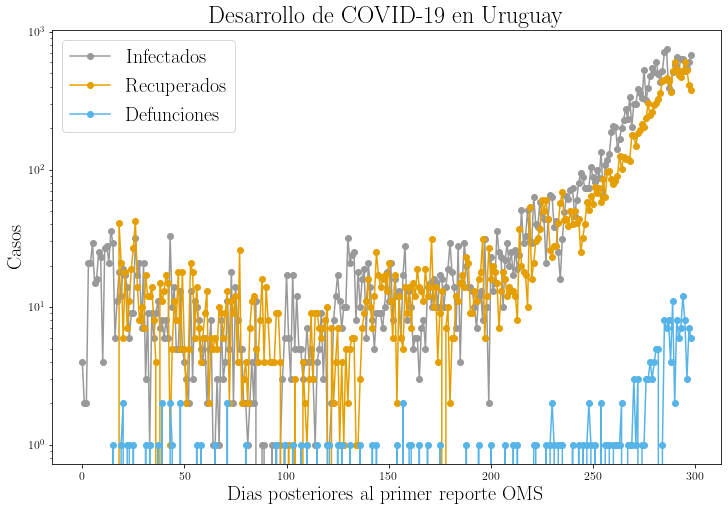

In [6]:
plt.figure(figsize=(12, 8))
plt.title("Desarrollo de COVID-19 en Uruguay")
plt.plot(URU.I, '-o', label="Infectados")
plt.plot(URU.R, '-o', label="Recuperados")
plt.plot(URU.D, '-o', label="Defunciones")
plt.yscale('log')
plt.ylabel("Casos")
plt.xlabel("Dias posteriores al primer reporte OMS")
plt.legend()

In [7]:
URU.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t,299.0,149.000000,86.458082,0.0,74.5,149.0,223.5,298.0
I,299.0,74.066890,152.851407,0.0,6.0,14.0,38.0,747.0
R,299.0,53.244147,114.364236,0.0,5.5,12.0,31.5,602.0
D,299.0,0.725753,1.684425,0.0,0.0,0.0,1.0,12.0


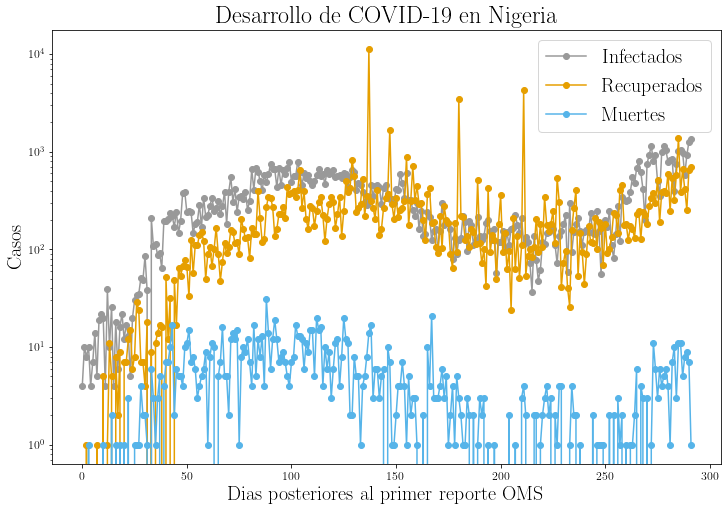

In [8]:
plt.figure(figsize=(12, 8))
plt.title("Desarrollo de COVID-19 en Nigeria")
plt.plot(NIG.I, '-o', label="Infectados")
plt.plot(NIG.R, '-o', label="Recuperados")
plt.plot(NIG.M, '-o', label="Muertes")
plt.yscale('log')
plt.ylabel("Casos")
plt.xlabel("Dias posteriores al primer reporte OMS")
plt.legend()

In [9]:
NIG.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t,292.0,145.500000,84.437354,0.0,72.75,145.5,218.25,291.0
I,292.0,317.455479,259.951360,0.0,132.75,237.0,462.25,1354.0
R,292.0,261.626712,735.731145,0.0,80.25,159.5,277.00,11188.0
M,292.0,4.523973,4.928643,0.0,1.00,3.0,7.00,31.0


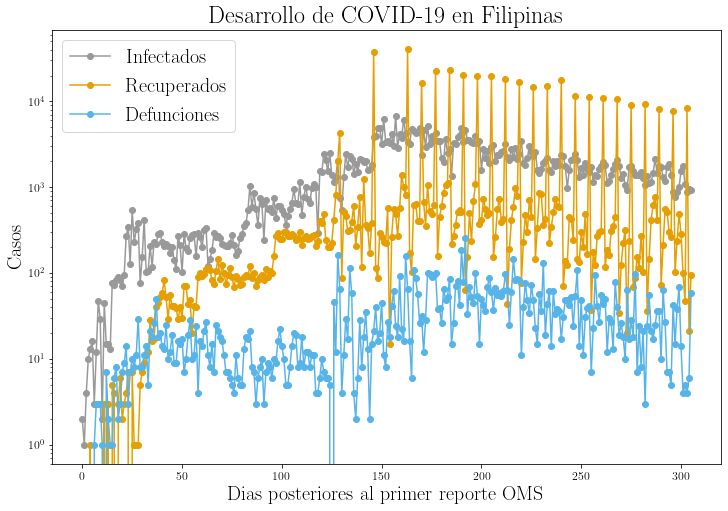

In [10]:
plt.figure(figsize=(12, 8))
plt.title("Desarrollo de COVID-19 en Filipinas")
plt.plot(FIL.I, '-o', label="Infectados")
plt.plot(FIL.R, '-o', label="Recuperados")
plt.plot(FIL.D, '-o', label="Defunciones")
plt.yscale('log')
plt.ylabel("Casos")
plt.xlabel("Dias posteriores al primer reporte OMS")
plt.legend()

In [11]:
FIL.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t,306.0,152.500000,88.478811,0.0,76.25,152.5,228.75,305.0
I,306.0,1567.614379,1354.937727,1.0,320.50,1384.0,2226.25,6725.0
R,306.0,1466.686275,4858.535099,0.0,82.00,226.5,469.25,40377.0
D,306.0,30.470588,33.260139,0.0,8.00,18.0,42.00,259.0


## 3. Modelos de ecuaciones diferenciales
### 3.1 SIR

<style>
p.comment {
background-color: #DBDBDB;
padding: 10px;
border: 1px solid black;
margin-left: 25px;
border-radius: 5px;
font-style: italic;
}
</style>

Es un modelo de ecuaciones diferenciales utilizado en epidemiología para modelar el compotamiento de enfermedades infecciosas, fue diseñado en 1927 por los médicos W. O. Kermack y A. G. McKendrick. Cuando una enfermedad es nueva como el **SARS-CoV 2 (Covid 19)** todos los habitantes de una población son candidatos a contraer dicha enfermedad con la misma probabilidad, con forme avanza el brote infeccioso diferentes condiciones hacen que aumente o disminuya la probabilidad de ser contagiado.
<p></p>
Un supuesto que se hace en este modelo es pensar en una población cerrada ante nacimientos y migración, por lo tanto la población inicial

<div class="alert alert-info">
    <ul>
      <li><strong>Susceptibles:</strong> personas que pueden contraer la enfermedad.</li>
      <li><strong>Infectados:</strong> personas que contrajeron la enfermedad y pueden contagiar a los demás.</li>
      <li><strong>Recuperados:</strong> personas que salieron de la enfermedad y adquieren inmunidad temporal.</li>
    </ul>
</div>


$$
\begin{eqnarray}
\frac{dS}{dt}&=& -\beta S\frac{I}{N} \\
\frac{dI}{dt}&=& \beta S\frac{I}{N} - \gamma I \\
\frac{dR}{dt}&=& \gamma I
\end{eqnarray}
$$


In [12]:
# Modelo
def SIR(z, t, beta, gamma):
    
    S, I, R= z
    
    return [-beta*(S/N)*I,beta*(S/N)*I-gamma*I,gamma*I]

In [13]:
N=3449299
def SURU():   
    return N-4     # I_0
def IURU():   
    return 4     # I_0
def RURU():
    return 0       # R_0
URU1=URU.loc[:,["t","I","R"]]
URU1=URU1[0:100]

In [14]:
modeloURU = pde.PDEmodel(URU1, SIR, [SURU,IURU,RURU], bounds=[(0, 1), (0,1)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [15]:
# Printing the initial condition
modeloURU.initial_condition

array([3449295,       4,       0])

In [16]:
%%time
modeloURU.fit()

    $\beta$  $\gamma$
0  0.031009  0.030074
Wall time: 2.24 s


In [17]:
modeloURU.best_params

,$\beta$,$\gamma$
0,0.031009,0.030074


In [18]:
modeloURU.best_error

87.98390589885699

In [19]:
%%time
modeloURU.likelihood_profiles()



Wall time: 3min 11s


In [20]:
modeloURU.result_profiles

,parameter,value,error
0,$\beta$,0.000000,106.709945
1,$\beta$,0.010101,98.849288
2,$\beta$,0.020202,91.268802
3,$\beta$,0.030303,87.996843
4,$\beta$,0.040404,89.572397
...,...,...,...
195,$\gamma$,0.959596,106.566016
196,$\gamma$,0.969697,106.593358
197,$\gamma$,0.979798,106.620097
198,$\gamma$,0.989899,106.646172


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


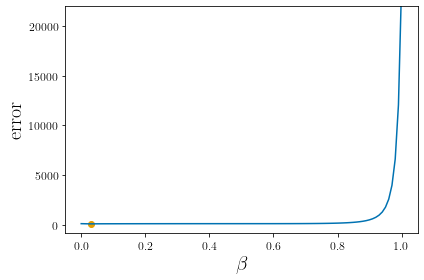

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


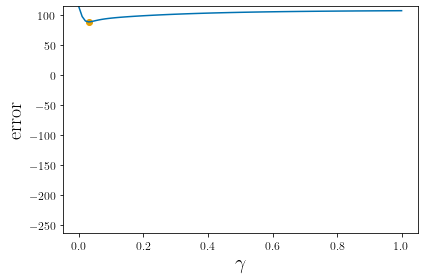

In [21]:
modeloURU.plot_profiles()

In [22]:
N=195874740
def SNIG():   
    return N-4     # I_0
def INIG():   
    return 4     # I_0
def RNIG():
    return 0       # R_0
NIG1=NIG.loc[:,["t","I","R"]]
NIG1=NIG1[0:100]

In [23]:
modeloNIG = pde.PDEmodel(NIG1, SIR, [SNIG,INIG,RNIG], bounds=[(0, 1), (0,1)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [24]:
# Printing the initial condition
modeloNIG.initial_condition

array([195874736,         4,         0])

In [25]:
%%time
modeloNIG.fit()

    $\beta$  $\gamma$
0  0.078274  0.023412
Wall time: 915 ms


In [26]:
modeloNIG.best_params

,$\beta$,$\gamma$
0,0.078274,0.023412


In [27]:
modeloNIG.best_error

10303.765906087636

In [28]:
%%time
modeloNIG.likelihood_profiles()



Wall time: 1min 19s


In [29]:
modeloNIG.result_profiles

,parameter,value,error
0,$\beta$,0.000000,60228.738781
1,$\beta$,0.010101,60081.592050
2,$\beta$,0.020202,56547.977086
3,$\beta$,0.030303,51160.748961
4,$\beta$,0.040404,39918.121312
...,...,...,...
195,$\gamma$,0.959596,54852.862752
196,$\gamma$,0.969697,54875.243889
197,$\gamma$,0.979798,54900.924365
198,$\gamma$,0.989899,54927.360290


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


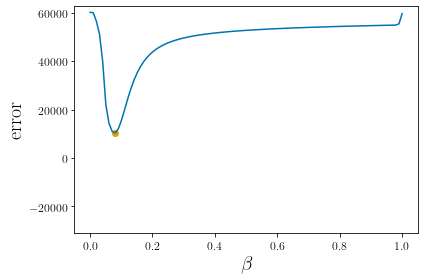

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


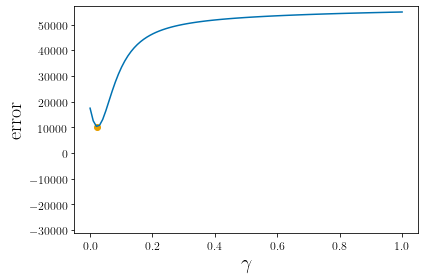

In [30]:
modeloNIG.plot_profiles()

In [31]:
N=106651922
def SFIL():   
    return N-2     # I_0
def IFIL():   
    return 2     # I_0
def RFIL():
    return 0       # R_0
FIL1=FIL.loc[:,["t","I","R"]]
FIL1=FIL1[0:100]

In [32]:
modeloFIL = pde.PDEmodel(FIL1, SIR, [SFIL,IFIL,RFIL], bounds=[(0, 1), (0,1)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [33]:
# Printing the initial condition
modeloFIL.initial_condition

array([106651920,         2,         0])

In [34]:
%%time
modeloFIL.fit()

    $\beta$  $\gamma$
0  0.078107  0.016645
Wall time: 1.23 s


In [35]:
modeloFIL.best_params

,$\beta$,$\gamma$
0,0.078107,0.016645


In [36]:
modeloFIL.best_error

18060.493004059004

In [37]:
%%time
modeloFIL.likelihood_profiles()



Wall time: 1min 16s


In [38]:
modeloFIL.result_profiles

,parameter,value,error
0,$\beta$,0.000000,56117.431782
1,$\beta$,0.010101,55719.206167
2,$\beta$,0.020202,54583.023106
3,$\beta$,0.030303,55187.122847
4,$\beta$,0.040404,46025.406211
...,...,...,...
195,$\gamma$,0.959596,53710.672810
196,$\gamma$,0.969697,53721.352860
197,$\gamma$,0.979798,53731.574959
198,$\gamma$,0.989899,54561.320861


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


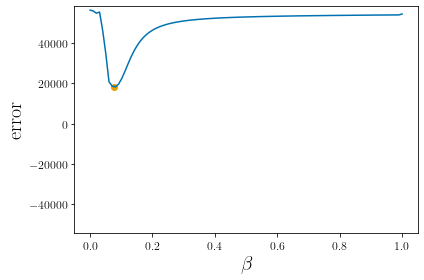

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


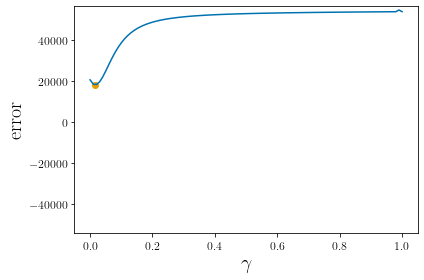

In [39]:
modeloFIL.plot_profiles()

### 3.2 SIR-D

En el modelo anterior se considero a los Recuperados como aquellas personas que ya no se podían infectar, es decir personas que son inmunes temporalmente y a los muertos, pero ahora veremos que pasa si los consideramos por separado.

<style>
p.comment {
background-color: #FFFFFF;
padding: 10px;
border: 1px solid black;
margin-left: 25px;
border-radius: 5px;
font-style: italic;
}
</style>

<div class="alert alert-info">
    <ul>
      <li><strong>Susceptibles:</strong> personas que pueden contraer la enfermedad.</li>
      <li><strong>Infectados:</strong> personas que contrajeron la enfermedad y pueden contagiar a los demás.</li>
      <li><strong>Recuperados:</strong> personas que salieron de la enfermedad y adquieren inmunidad temporal.</li>
      <li><strong>Defunciones:</strong> personas que salieron de la enfermedad y murieron.</li>
    </ul>
</div>

$$
\begin{eqnarray}
\frac{dS}{dt}&=& -\beta S\frac{I}{N} \\
\frac{dI}{dt}&=& \beta S\frac{I}{N} - \gamma I - \epsilon D \\
\frac{dR}{dt}&=& \gamma I \\
\frac{dD}{dt}&=& \epsilon D 
\end{eqnarray}
$$


In [40]:
def SIRD(z, t, beta1, gamma1, epsilon1):
    
    S, I, R, D = z
    
    return [-beta1*(S/N)*I, beta1*(S/N)*I-gamma1*I-epsilon1*D, gamma1*I, epsilon1*D]

In [41]:
N=3449299
# Iniciales
def SUR1():
    return N-4   # S_0
def IUR1():   
    return 4     # I_0
def RUR1():
    return 0       # R_0
def DUR1():
    return 0       # D_0

In [42]:
modeloUR1 = pde.PDEmodel(URU[0:100], SIRD, [SUR1,IUR1,RUR1,DUR1], bounds=[(0, 1), (0,1),(0,1)], 
                        param_names=[r'$\beta_1$', r'$\gamma_1$', r'$\epsilon_1$'], nvars=4, 
                         ndims=0, nreplicates=1, obsidx=[1,2,3], outfunc=None)

In [43]:
# Printing the initial condition
modeloUR1.initial_condition

array([3449295,       4,       0,       0])

In [44]:
%%time
modeloUR1.fit()

   $\beta_1$  $\gamma_1$  $\epsilon_1$
0   0.031009    0.030075      0.536046
Wall time: 1.38 s


In [45]:
modeloUR1.best_params

,$\beta_1$,$\gamma_1$,$\epsilon_1$
0,0.031009,0.030075,0.536046


In [46]:
modeloUR1.best_error

58.77260390800041

In [47]:
%%time
modeloUR1.likelihood_profiles()



Wall time: 4min 49s


In [48]:
modeloUR1.result_profiles

,parameter,value,error
0,$\beta_1$,0.000000,71.256375
1,$\beta_1$,0.010101,66.016168
2,$\beta_1$,0.020202,60.958794
3,$\beta_1$,0.030303,58.781242
4,$\beta_1$,0.040404,59.831767
...,...,...,...
295,$\epsilon_1$,0.959596,58.776411
296,$\epsilon_1$,0.969697,58.785956
297,$\epsilon_1$,0.979798,58.779536
298,$\epsilon_1$,0.989899,58.773719


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


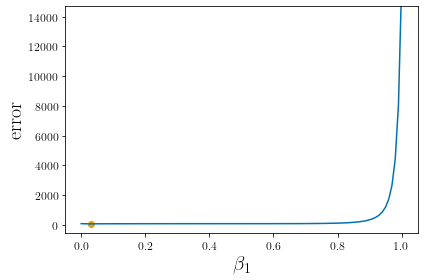

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


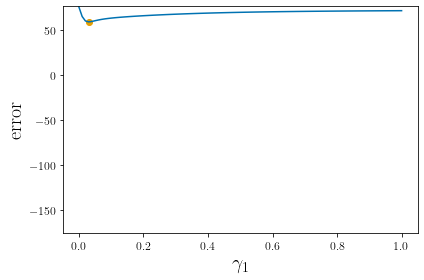

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


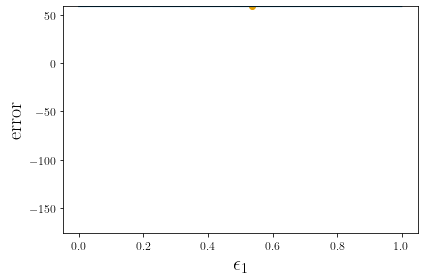

In [49]:
modeloUR1.plot_profiles()

In [50]:
N=195874740
# Iniciales
def SNI1():
    return N-4   # S_0
def INI1():   
    return 4     # I_0
def RNI1():
    return 0       # R_0
def DNI1():
    return 0       # D_0

In [51]:
modeloNI1 = pde.PDEmodel(NIG[0:100], SIRD, [SNI1,INI1,RNI1,DNI1], bounds=[(0, 1), (0,1),(0,1)], 
                        param_names=[r'$\beta_1$', r'$\gamma_1$', r'$\epsilon_1$'], nvars=4, 
                         ndims=0, nreplicates=1, obsidx=[1,2,3], outfunc=None)

In [52]:
# Printing the initial condition
modeloNI1.initial_condition

array([195874736,         4,         0,         0])

In [53]:
%%time
modeloNI1.fit()

   $\beta_1$  $\gamma_1$  $\epsilon_1$
0   0.078274    0.023412      0.271137
Wall time: 1.9 s


In [54]:
modeloNI1.best_params

,$\beta_1$,$\gamma_1$,$\epsilon_1$
0,0.078274,0.023412,0.271137


In [55]:
modeloNI1.best_error

6889.723937980477

In [56]:
%%time
modeloNI1.likelihood_profiles()



Wall time: 5min 13s


In [57]:
modeloNI1.result_profiles

,parameter,value,error
0,$\beta_1$,0.000000,40140.650568
1,$\beta_1$,0.010101,39359.856695
2,$\beta_1$,0.020202,37700.504679
3,$\beta_1$,0.030303,38860.214788
4,$\beta_1$,0.040404,26632.531743
...,...,...,...
295,$\epsilon_1$,0.959596,6889.871270
296,$\epsilon_1$,0.969697,6889.800872
297,$\epsilon_1$,0.979798,6889.987931
298,$\epsilon_1$,0.989899,6889.791213


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


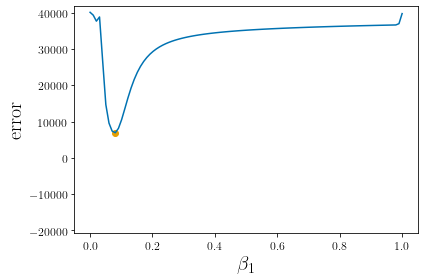

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


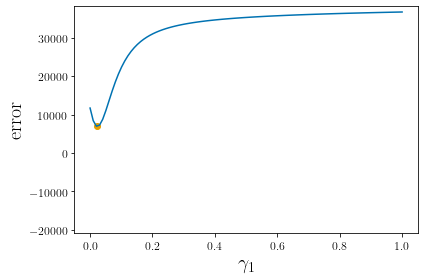

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


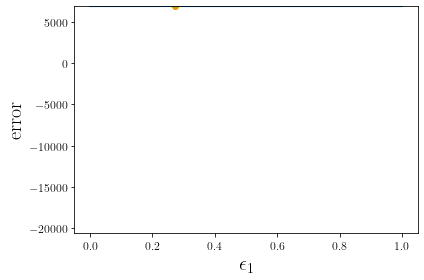

In [58]:
modeloNI1.plot_profiles()

In [59]:
N=106651922
# Iniciales
def SFI1():
    return N-2   # S_0
def IFI1():   
    return 2     # I_0
def RFI1():
    return 0       # R_0
def DFI1():
    return 0       # D_0

In [60]:
modeloFI1 = pde.PDEmodel(FIL[0:100], SIRD, [SFI1,IFI1,RFI1,DFI1], bounds=[(0, 1), (0,1),(0,1)], 
                        param_names=[r'$\beta_1$', r'$\gamma_1$', r'$\epsilon_1$'], nvars=4, 
                         ndims=0, nreplicates=1, obsidx=[1,2,3], outfunc=None)

In [61]:
# Printing the initial condition
modeloFI1.initial_condition

array([106651920,         2,         0,         0])

In [62]:
%%time
modeloFI1.fit()

   $\beta_1$  $\gamma_1$  $\epsilon_1$
0   0.078107    0.016644      0.697196
Wall time: 2.1 s


In [63]:
modeloFI1.best_params

,$\beta_1$,$\gamma_1$,$\epsilon_1$
0,0.078107,0.016644,0.697196


In [64]:
modeloFI1.best_error

12101.69866970018

In [65]:
%%time
modeloFI1.likelihood_profiles()



Wall time: 5min 12s


In [66]:
modeloFI1.result_profiles

,parameter,value,error
0,$\beta_1$,0.000000,37479.185447
1,$\beta_1$,0.010101,37426.914812
2,$\beta_1$,0.020202,36394.017278
3,$\beta_1$,0.030303,34581.153465
4,$\beta_1$,0.040404,30736.495022
...,...,...,...
295,$\epsilon_1$,0.959596,12102.091455
296,$\epsilon_1$,0.969697,12104.842966
297,$\epsilon_1$,0.979798,12102.338698
298,$\epsilon_1$,0.989899,12103.135864


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


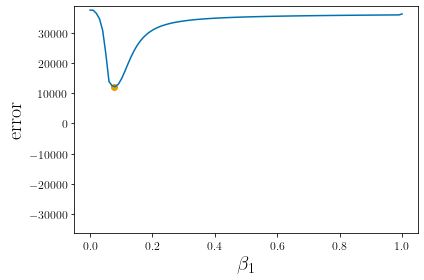

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


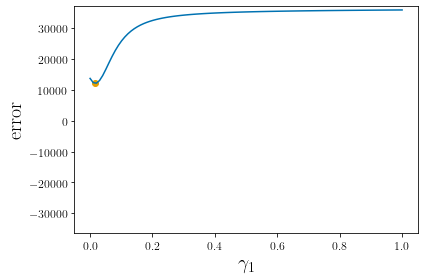

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


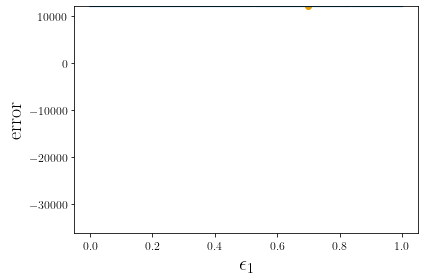

In [67]:
modeloFI1.plot_profiles()

## 4. Conclusiones

Ahora podemos comparar los 3 casos con sus tasas de contagio, tasas de recuperación y tasas de mortalidad durante los 100 días posteriores al primer contagio:

|Población | $\beta$ | $\gamma$ | $\frac{\beta}{\gamma}$ |
|------|-------|----|----|
| Uruguay  | 0.031009 |  0.030074    |  1.03109  |
| Nigeria  | 0.078274 |  0.023412    |  3.34333  |
| Filipinas | 0.078107 |  0.016645   |  4.69252  |


|Población | $\beta$ | $\gamma$ | $\frac{\beta}{\gamma}$ | $\epsilon$
|------|-------|----|----|----|
| Uruguay  | 0.031009  |  0.030075  |  1.031056  | 0.536046 |
| Nigeria  | 0.078274  |  0.023412  |  3.343328  | 0.271137 |
| Filipinas | 0.078107 |  0.016644  |  4.692802  | 0.697196 |

Como podemos ver, cada país tiene un comportamiento muy diferente debida a la forma en la que se manejó la pandemia, pues Uruguay ha tenido pocos contagios a largo del tiempo hasta el mes de noviembre que es donde ha empezado a crecer de forma exponencial, por esa razón es que pareciera ser poco contagiosa la enfermedad durante sus primeros días. 

El caso de Nigeria, podríamos categorizarlo en un caso estándar, pues la tasa de contagios es muy similar a la que se estimó en un principio por la $OMS$, además en este caso los contagios sí tuvieron  un comportamiento de ola, ya que se ve una elevación inicial con los primeros contagios y después una caida, hasta que comienza un rebrote o una segunda ola de contagios y por esta razón no podríamos modelar con todos los datos.


Por último Filipinas tiene otra particularidad, primero podemos notar que parece ser más contagiosa la enfermedad (1 persona puede contagiar a casi 5 personas), así mismo, el comportamiento de sus contagios sólo ha seguido una ola de contagios, por lo que podríamos pensar que se ha logrado contener la enfermedad.

Por otra parte, entre el modelo $SIR$ y $SIR-D$ no hay cambios drásticos en la estimación de los parámetros $\alpha$ y $\beta$, pero sí nos da información adicional, ya que podemos ver la tasa de mortalidad, con estos resultados la enfermedad pareciera más mortal en Filipinas y menos mortal en Nigeria.

